In [1]:
import pandas as pd , os, glob, numpy as np
from sklearn.preprocessing import Imputer , LabelEncoder , MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import f_classif
from sklearn_pandas import DataFrameMapper
from sklearn.model_selection import train_test_split 
from keras.models import Model
from keras.layers import Input, Dense, Flatten, Embedding, concatenate , Reshape, Dropout, Conv1D
from keras import initializers
from utils import *

import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [2]:
fpath = glob.glob(os.path.join(os.getcwd(),'DA/life*'))

In [3]:
df = pd.read_sas(fpath[0])
df['target'] = df['premium'].apply(lambda x: int(x>0)); df.drop('premium', axis=1, inplace=True);

In [4]:
cat, num = sum_cat_num(df, 'target')

             risk_score       gender num_public_record_items  \
count             28749          NaN                   28749   
mean            808.773          NaN                 1.18213   
std             155.635          NaN                 3.00736   
min                 222          NaN                       0   
25%                 720          NaN                       0   
50%                 863          NaN                       0   
75%                 931          NaN                       1   
max                 994          NaN                      65   
counts            28749        28749                   28749   
uniques             721            4                      44   
missing               0            0                       0   
missing_perc         0%           0%                      0%   
types           numeric  categorical                 numeric   

             age_most_rec_pub_record collection_items bankruptcy_prior  \
count                        

In [5]:
df_yes = df.loc[df.target==1]  # oversampling 
df_no = df.loc[df.target==0]
np.random.seed(57)
df_no_ = df_no.loc[np.random.rand(27887) <= (4885/27887.0)]
df_data = pd.concat([df_yes, df_no_])

In [6]:
cat, num = sum_cat_num(df_data, 'target')

             risk_score       gender num_public_record_items  \
count              5781          NaN                    5781   
mean            795.605          NaN                 1.27988   
std             160.837          NaN                 3.22536   
min                 256          NaN                       0   
25%                 696          NaN                       0   
50%                 847          NaN                       0   
75%                 927          NaN                       1   
max                 993          NaN                      49   
counts             5781         5781                    5781   
uniques             665            4                      35   
missing               0            0                       0   
missing_perc         0%           0%                      0%   
types           numeric  categorical                 numeric   

             age_most_rec_pub_record collection_items bankruptcy_prior  \
count                        

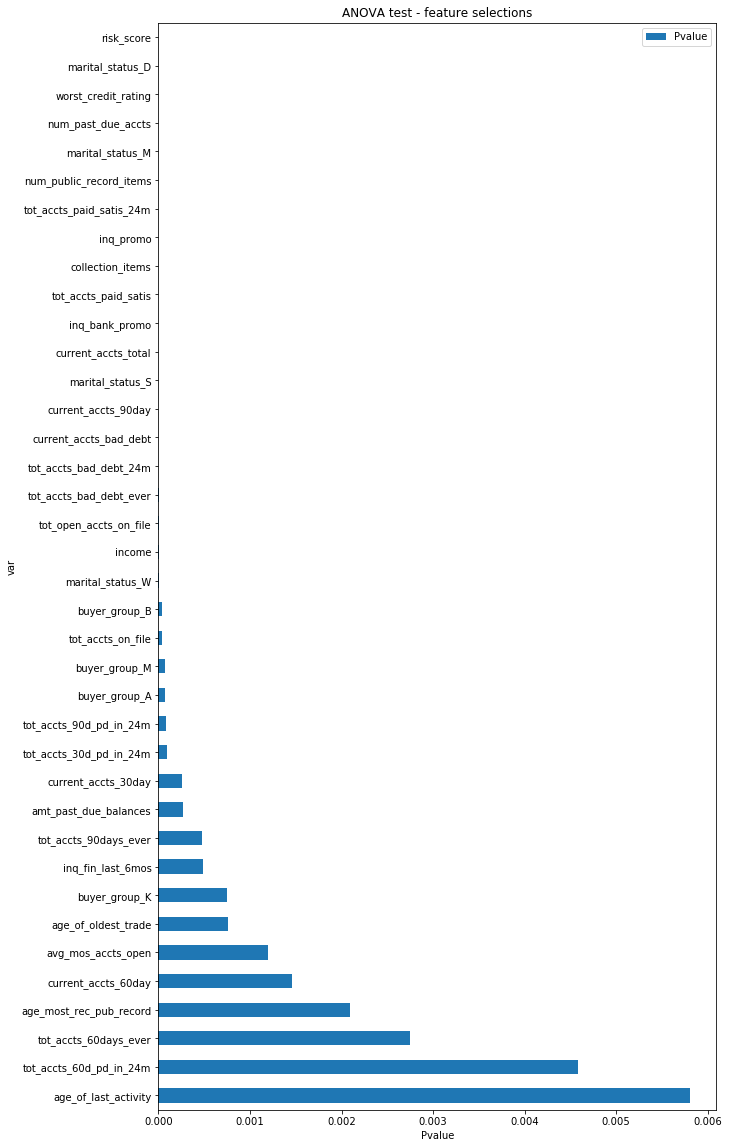

In [7]:
df_imp = feature_selection(df_data, num, cat, 'target')
P1 = df_imp.loc[df_imp['Pvalue']<=0.02]
P1.plot(kind='barh', y='Pvalue', x='var' ,figsize=(10,20))
plt.title('ANOVA test - feature selections')
plt.xlabel('Pvalue')

In [8]:
var_imp = [u'age_of_most_recent_inq',
 u'age_of_youngest_trade',
 u'age_actual',
 u'avg_mos_accts_open',
 u'tot_bal_open_accts',
 u'income',
 u'age_of_oldest_trade',
 u'risk_score',
          u'marital_status', u'buyer_group']

num_v = [u'age_of_most_recent_inq',
 u'age_of_youngest_trade',
 u'age_actual',
 u'avg_mos_accts_open',
 u'tot_bal_open_accts',
 u'income',
 u'age_of_oldest_trade',
 u'risk_score']
cat_v = [u'marital_status', u'buyer_group']



In [11]:
X_train, X_test, y_train, y_test = train_test_split(df_data[var_imp], df_data['target'], test_size=0.3, random_state=57,stratify=df_data['target'])

In [12]:
cat_maps = [(o, LabelEncoder()) for o in cat_v]
contin_maps = [([o], MinMaxScaler()) for o in num_v]

In [13]:
cat_mapper = DataFrameMapper(cat_maps)
cat_map_fit = cat_mapper.fit(X_train)
cat_cols = len(cat_map_fit.features)


In [14]:
contin_mapper = DataFrameMapper(contin_maps)
contin_map_fit = contin_mapper.fit(X_train)
contin_cols = len(contin_map_fit.features)


In [15]:
def cat_preproc(dat):
    return cat_map_fit.transform(dat).astype(np.int64)

def contin_preproc(dat):
    return contin_map_fit.transform(dat).astype(np.float32)


In [16]:
cat_map_train = cat_preproc(X_train)
cat_map_test = cat_preproc(X_test)
contin_map_train = contin_preproc(X_train)
contin_map_test = contin_preproc(X_test)

In [17]:
def split_cols(arr): return np.hsplit(arr,arr.shape[1])
def cat_map_info(feat): return feat[0], len(feat[1].classes_)

In [18]:
def get_contin(feat):
    name = feat[0][0]
    inp = Input((1,), name=name+'_in')
   # b2 = Reshape((1,1))(inp)
    return inp, Dense(1, name=name+'_d', kernel_initializer='glorot_uniform')(inp)

def get_emb(feat):
    name, c = cat_map_info(feat)
    #c2 = cat_var_dict[name]
    c2 = (c+1)//2
    if c2>50: c2=50
    inp = Input((1,), dtype='int64', name=name+'_in')
    # , W_regularizer=l2(1e-6)
    x = Embedding(c, c2, input_length=1, embeddings_initializer='uniform')(inp)
    #x = Conv1D(50, 2, activation='relu')(x)
    #x = MaxPooling1D(2)(x)
    #x = Conv1D(50, 2, activation='relu')(x)
    #x = MaxPooling1D(2)(x)
    u = Flatten()(x)
    return inp,u


In [19]:
map_train = split_cols(cat_map_train) + split_cols(contin_map_train)
map_test = split_cols(cat_map_test) + split_cols(contin_map_test)

In [20]:
conts = [get_contin(feat) for feat in contin_map_fit.features]
contin_d = [d for inp,d in conts]
contin_inp = [ inp for inp, d in conts]

In [21]:
embs = [get_emb(feat) for feat in cat_map_fit.features]
cat_emb = [emb for inp,emb in embs]
cat_inp = [inp for inp,emb in embs]

In [22]:
x = concatenate( cat_emb + contin_d , axis=-1)
x = Dropout(0.02)(x)
x = Dense(1000, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(500, activation='relu')(x)
output = Dense(1, activation='sigmoid')(x)


In [23]:
model = Model(inputs= cat_inp + contin_inp , outputs= output)
#model = Model([inp for inp,emb in embs] + [inp for inp,d in conts], x)
model.compile('SGD', loss="binary_crossentropy", metrics=['accuracy'])
#model.compile(Adam(), 'mse')

In [24]:
model.fit(map_train, y_train, batch_size=128, epochs=10,
                 verbose=1, validation_data=(map_test, y_test))

Train on 4046 samples, validate on 1735 samples
Epoch 1/10
4046/4046 [==============================] - 0s - loss: 0.6217 - acc: 0.8455 - val_loss: 0.5593 - val_acc: 0.8507